# Heat Waves - AIFS
---

[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ECMWFCode4Earth/open-data-explorer/blob/main/openDataVisio/examples/Colab/z500-t850-t2m.ipynb)

In the end of April 2025, Western European countries experienced unseasonably warm weather. This example shows analysis of the selected parameters:
- [`z`](https://codes.ecmwf.int/grib/param-db/129) geopotential at constant pressure level 500 hPa,
- [`t`](https://codes.ecmwf.int/grib/param-db/130) temperature at 850 hPa, and
- [`2t`](https://codes.ecmwf.int/grib/param-db/167) 2 metre temperature of the **AIFS-Single** datasets on 30 April at 12 UTC in France (48.3° N, 4.1° E).

:::{note}
[Geopotential height](https://codes.ecmwf.int/grib/param-db/156) will be calculated from geopotential, because this parameter is not part of the AIFS products.
:::

## 1. Set Up Your Environment and Find ECMWF Open Data
Open data will be downloaded from a publicly available [Amazon S3 Bucket](../datadownload/find-data.md). First, the following Python libraries need to be installed in the current Jupyter kernel:
- `ecmwf-opendata` to download data and
- `earthkit` to analyse and plot the data.

:::{seealso}
More detailed information about how to install Python packages is available on the [Retrieve Data](../datadownload/data-download.ipynb) website.
:::
If the packages are not installed yet, uncomment the code below and run it.

In [14]:
# !pip3 install earthkit ecmwf-opendata

In [1]:
from ecmwf.opendata import Client
import earthkit.data as ekd
import earthkit.plots as ekp
import earthkit

import os

(content:references:listParam_hwa)=
### List of parameters to retrieve from open datasets
The selected values below can be modified.
- Parameters available on pressure levels:

In [2]:
PARAM_PL = ["z", "t"]
LEVELS = [500, 850]
LEVELTYPE = "pl"

DATES = [20250429, 20250430, 20250501]
TIME = 0
STEPS = 12
STREAM = "oper"
TYPE = "fc"
MODEL = "aifs-single"

- Parameters available on a single level:

In [64]:
PARAM_SFC = ["2t"]
LEVELTYPE = "sfc"

DATES = [20250429, 20250430, 20250501]
TIME = 0
STEPS = 12
STREAM = "oper"
TYPE = "fc"
MODEL = "aifs-single"

### Data and plots directories

In [ ]:
DATADIR = './data_dir/'
os.makedirs(DATADIR, exist_ok=True)

PLOTSDIR = './plots/'
os.makedirs(PLOTSDIR, exist_ok=True)

### Get the data using the ECMWF Open Data API

In [3]:
def get_open_data(date, time, step, stream, _type, model, param, leveltype, levelist=[]):
    client = Client(source="aws")
    list_of_files = []
    # Get the data for all dates
    for _date in DATES:
        filename = f"{DATADIR}{model}_{''.join(param)}_{''.join(map(str, levelist))}_{_date}.grib2" if levelist else f"{DATADIR}{model}_{''.join(param)}_{leveltype}_{_date}.grib2"
        data = client.retrieve(
            date=_date,
            time=time,
            step=step,
            stream=stream,
            type=_type,
            levtype=leveltype,
            levelist=levelist,
            param=param,
            model=model,
            target=filename
            )
        list_of_files.append(filename)
    return data, list_of_files

## 2. Geopotential at 500 hPa and temperature at 850 hPa
When using the `ls()` method, a list of all the fields in the file we downloaded will be displayed.

In [4]:
data, list_of_files = get_open_data(date=DATES,
                                    time=TIME,
                                    step=STEPS,
                                    stream=STREAM,
                                    _type=TYPE,
                                    model=MODEL,
                                    param=PARAM_PL,
                                    leveltype=LEVELTYPE,
                                    levelist=LEVELS)

# Select AIFS model data from 29 April 2025
ds = ekd.from_source("file", list_of_files[0])
ds.ls()

Model 'aifs-single' does not match the client model 'ifs', using model 'aifs-single' from retrieve
                                                                                

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,z,isobaricInhPa,850,20250429,0,12,fc,None,regular_ll
1,ecmf,t,isobaricInhPa,850,20250429,0,12,fc,None,regular_ll
2,ecmf,z,isobaricInhPa,500,20250429,0,12,fc,None,regular_ll
3,ecmf,t,isobaricInhPa,500,20250429,0,12,fc,None,regular_ll


:::{warning}
The following warning is displayed when we execute the above function for the very first time: "Model 'aifs-single' does not match the client model 'ifs', using model 'aifs-single' from retrieve".
:::

Only the parameters and their levels which we specified above will be returned when we apply the `sel()` function.

In [5]:
t850 = ds.sel({"level": 850, "shortName": "t"})
t850.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,t,isobaricInhPa,850,20250429,0,12,fc,None,regular_ll


In the cell below, the geopotential on 500 hPa is selected and a new fieldlist with a single field containing the new values and metadata is created.

In [11]:
z500 = ds.sel({"level": 500, "shortName": "z"})[0]
z500.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,z,isobaricInhPa,500,20250429,0,12,fc,None,regular_ll


:::{tip}
See another example of how to [use the metadata object on the GRIB data](https://earthkit-data.readthedocs.io/en/latest/examples/grib_metadata_object.html#The-metadata-object).
:::

:::{important}
For single fields, one has to use the bracket operator to fetch the first element from a list and access as well as modify its metadata: <br>
```python
ds.sel({"level": 500, "shortName": "z"}) # MaskIndex(GRIBReader(aifs-single_zt_500850_20250429.grib2),[2])
ds.sel({"level": 500, "shortName": "z"})[0] # GribField(z,500,20250429,0,12,None)
```
:::

Geopotential height is calculated by dividing the geopotential by the Earth's mean gravitational acceleration, g (=9.80665 m s-2). In the ECMWF Open Charts, it is plotted in geopotential decameters. Therefore, our result also need to be divided by 10.

In [7]:
ds_gh500 = z500.values / (9.80665 * 10)

To change metadata values, put key value pairs to the `override()` function.

In [8]:
md_gh500 = z500.metadata().override(shortName="gh")
md_gh500["shortName"], md_gh500["level"]

('gh', 500)

When using the `head()` method, a selected number of rows `n` and information about the fields in the file we downloaded will be displayed.
:::{tip}
See further examples of how to [inspect content of the GRIB data](https://earthkit-data.readthedocs.io/en/latest/examples/grib_metadata.html).
:::

In [9]:
gh500 = ekd.FieldList.from_array(ds_gh500, md_gh500)
gh500.head()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,gh,isobaricInhPa,500,20250429,0,12,fc,None,regular_ll


## 3. 2-metre temperature
The input values can be set [here](#content:references:listParam_hwa).

In [44]:
data, list_of_files = get_open_data(date=DATES,
                                    time=TIME,
                                    step=STEPS,
                                    stream=STREAM,
                                    _type=TYPE,
                                    model=MODEL,
                                    param=PARAM_SFC,
                                    leveltype=LEVELTYPE,
                                    levelist=[])

# Select data from 30 April 2025
ds_2t = ekd.from_source("file", list_of_files[1])
ds_2t.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,2t,heightAboveGround,2,20250430,0,12,fc,None,regular_ll


There is no need to convert temperature from Kelvin to Celsius, because in the `earthkit-plots` library we can set units of it.

In [45]:
t2m = ds_2t.sel(shortName="2t")
t2m.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,2t,heightAboveGround,2,20250430,0,12,fc,None,regular_ll


## 4. Data visualisation

The plot below shows analysis of T850 and z500 on 29 April 2025.

:::{note}
The `transform_first` keyword argument indicates that the `earthkit-plot` package will transform the points before generating the contours which speed up the process of plotting the data.
:::

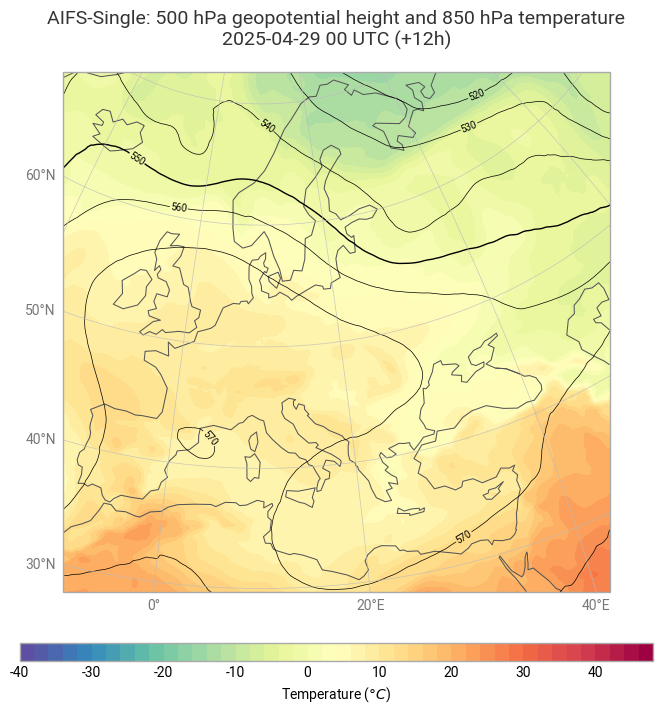

In [13]:
chart = ekp.Map(domain="Europe")

t850_shade = ekp.styles.Style(
    colors="Spectral_r",
    levels=range(-40, 50, 2),
    extend="both",
    units="celsius",
)

chart.contourf(t850, style=t850_shade)

chart.contour(gh500,
              levels={"step": 10, "reference": 550},
              linecolors="black",
              linewidths=[0.5, 1, 0.5, 0.5],
              labels = True,
              legend_style = None,
              transform_first=True)

chart.coastlines(resolution="low")
chart.gridlines()

chart.legend(location="bottom", label="{variable_name} ({units})")

chart.title(
    "AIFS-Single: 500 hPa geopotential height and 850 hPa temperature\n"
    "{base_time:%Y-%m-%d %H} UTC (+{lead_time}h)\n",
    fontsize=14, horizontalalignment="center",
)
chart.save(f"{PLOTSDIR}{''.join(PARAM_PL)}_{MODEL}_{DATES[0]}{TIME}-{STEPS}h.png")
chart.show()

The plot below shows analysis of 2 metre temperature on 30 April at 00 UTC.

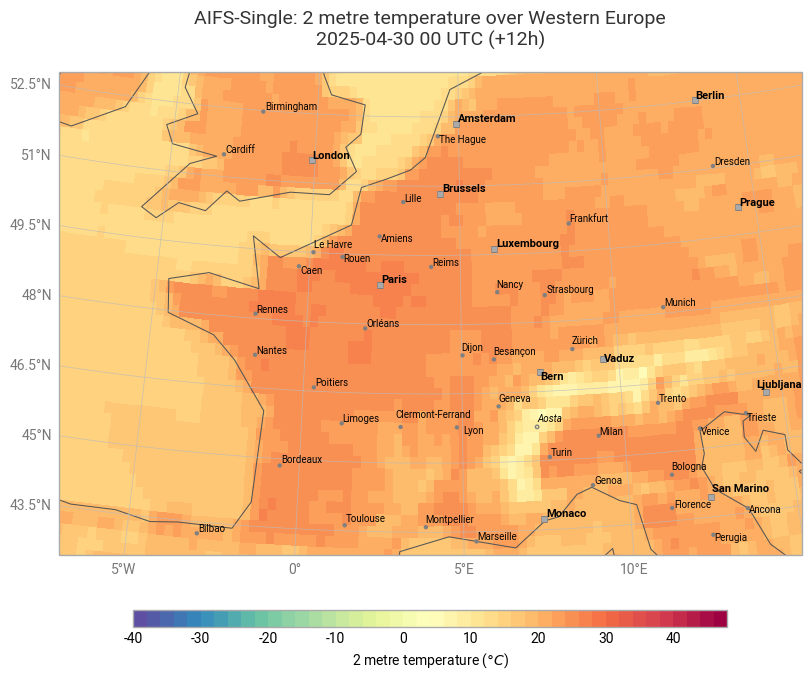

In [67]:
chart = ekp.Map(domain=[-7, 15, 43, 53])

t2m_shade = ekp.styles.Style(
    colors="Spectral_r",
    levels=range(-40, 50, 2),
    extend="both",
    units="celsius",
)

chart.grid_cells(t2m, style=t2m_shade)

chart.title(
    "AIFS-Single: {variable_name} over Western Europe\n"
    "{base_time:%Y-%m-%d %H} UTC (+{lead_time}h)\n",
    fontsize=14, horizontalalignment="center",
)

chart.coastlines(resolution="low")
chart.gridlines()
chart.cities(adjust_labels=True)

chart.legend(location="bottom", label="{variable_name} ({units})")

chart.save(f"{PLOTSDIR}{''.join(PARAM_SFC)}_{MODEL}_{DATES[1]}{TIME}-{STEPS}h.png")
chart.show()